**Toy examples**

In this part of the practical session, you will play with some toy data to better understand the classification algorithms seen this morning.

Please answer all questions

**Deadline**: Upload this notebook, the one about Emotion Recognition and the answers to the theoretical questions to E-Campus. Please verify the exact deadline on E-Campus.

Let's first load the needed packages.

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import rc

import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import time

%matplotlib inline
np.random.seed(seed=666)

Here, we define some functions useful for generating and plotting the data

In [2]:
def gaussian_data_generation(n, mean, cov, noise_std):
    """
    create data which follows a multivariate Gaussian distribution
    a white (Gaussian) noise is then added to the data
    """
    assert cov.shape[0] == cov.shape[1], "Please use only square covariance matrix"
    assert len(mean) == cov.shape[0], "the dimension of the mean should be equal to the dimension of the covariance matrix"

    X = np.random.multivariate_normal(mean, cov, n) # actual data
    X = X + np.random.multivariate_normal(np.zeros(len(mean)), noise_std ** 2 *np.eye(len(mean)), n)  # we add white noise to the data

    return X

def frontiere(f, X, y, step=50):
    # decision boundary of classifier f
    # construct cmap

    min_tot = np.min(X)
    max_tot = np.max(X)
    delta = (max_tot - min_tot) / step
    xx, yy = np.meshgrid(np.arange(min_tot, max_tot, delta),
                         np.arange(min_tot, max_tot, delta))
    z = np.array([f(vec) for vec in np.c_[xx.ravel(), yy.ravel()]])
    z = z.reshape(xx.shape)
    labels = np.unique(z)
    color_blind_list = sns.color_palette("colorblind", labels.shape[0])
    sns.set_palette(color_blind_list)
    my_cmap = ListedColormap(color_blind_list)
    plt.imshow(z, origin='lower', extent=[min_tot, max_tot, min_tot, max_tot],
               interpolation="mitchell", alpha=0.80, cmap=my_cmap)

    ax = plt.gca()
    cbar = plt.colorbar(ticks=labels)
    cbar.ax.set_yticklabels(labels)

    k = np.unique(y).shape[0]
    color_blind_list = sns.color_palette("colorblind", k)
    for i, label in enumerate(y):
        plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                    s=80, marker=symlist[int(label)])
    plt.ylim([min_tot, max_tot])
    plt.xlim([min_tot, max_tot])
    ax.get_yaxis().set_ticks([])
    ax.get_xaxis().set_ticks([])

def class_int_round(z, n_class):
    """ rounding needed to go from real to integer values
     clips the output to values [0,n_class-1]
    """
    output = np.round(z).astype(int)
    if isinstance(z, np.ndarray):
        j = z < 0
        output[j] = 0
        k = z > n_class - 1
        output[k] = n_class - 1
    else:
        if output < 0:
            output = 0
        else:
            if output > n_class - 1:
                output = n_class - 1
    return output

The next function is the one you will use to create the toy data. You can choose among three scenarios: 2, 3 or 4 classes. Each class is composed of 2D points sampled from a multivariate Gaussian distribution. You can choose the number of samples, average and covariance matrix for each class.

In [3]:
def generate_scenario(n_classes=3):
    """
    generate data samples X and returns labels y. 80 samples for each class

    These data is sampled from different gaussian distributions with means and cov depending on the number of classes
    each class ill remain th esame in all scenarios and increasing the number will add new class
    """
    if n_classes == 2:
        # Example with 2 classes
        n_0=80
        mean_0 = [0, 0]
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)

        n_1=80
        mean_1 = [3, 2]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)

        X=np.concatenate((X_0,X_1))
        y=np.concatenate((y_0,y_1))

    elif n_classes == 3:
        # Example with 3 classes
        n_0=80
        mean_0 = [0, 0]
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)

        n_1=80
        mean_1 = [2, 2]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)

        n_2=80
        mean_2 = [3, 3]
        cov_2 = np.array([[0.5, 0.1], [0.1, 1]])
        X_2=gaussian_data_generation(n_2, mean_2, cov_2, 0.1)
        y_2=2*np.ones(n_2)

        X=np.concatenate((X_0,X_1,X_2))
        y=np.concatenate((y_0,y_1,y_2))
    elif n_classes == 4:
        # Example with 4 classes
        n_0=80
        mean_0 = [0, 0]
        cov_0 = np.array([[1, 0.1], [0.1, 0.9]])
        X_0=gaussian_data_generation(n_0, mean_0, cov_0, 0.1)
        y_0=np.zeros(n_0)

        n_1=80
        mean_1 = [3, 3]
        cov_1 = np.array([[0.1, 0], [0, 0.5]])
        X_1=gaussian_data_generation(n_1, mean_1, cov_1, 0.1)
        y_1=np.ones(n_1)

        n_2=80
        mean_2 = [0, 3]
        cov_2 = np.array([[0.5, 0.1], [0.1, 1]])
        X_2=gaussian_data_generation(n_2, mean_2, cov_2, 0.1)
        y_2=2*np.ones(n_2)

        n_3=80
        mean_3 = [3, 0]
        cov_3 = np.array([[0.9, 0.15], [0.15, 0.8]])
        X_3=gaussian_data_generation(n_3, mean_3, cov_3, 0.1)
        y_3=3*np.ones(n_3)

        X=np.concatenate((X_0,X_1,X_2,X_3))
        y=np.concatenate((y_0,y_1,y_2,y_3))

    return X, y

Let's choose a scenario and generate some data

In [43]:
######## PARAMETER TO CHOOSE THE SCENARIO (number of classes) #######
n_classes=4
#####################################################################
#fix the random seed for reproducable results
np.random.seed(42)

X, y = generate_scenario(n_classes)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Let's plot the data

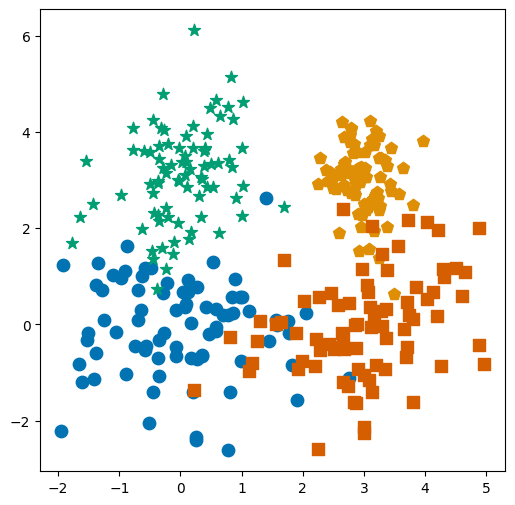

In [15]:
fig1 = plt.figure(figsize=(6, 6))
ax = plt.gca()
min_tot = np.min(X)
max_tot = np.max(X)
symlist = ['o', 'p', '*', 's', '+', 'x', 'D', 'v', '-', '^']
k = np.unique(y).shape[0]
color_blind_list = sns.color_palette("colorblind", k)
for i, label in enumerate(y):
    plt.scatter(X[i, 0], X[i, 1], c=[color_blind_list[int(y[i])]],
                s=80, marker=symlist[int(label)])

As first classifier, we can use a simple linear regression where we  transform in integers the predictions.

 **Question**: look at the function 'class_int_round'. Explain what it does.

The function class_int_round returns the integer closest to the given value in the interval [0,n_class-1]. This is useful for the case where we want to get an index of a class out of a real number. However, this is not the optimal encoding form for the data.

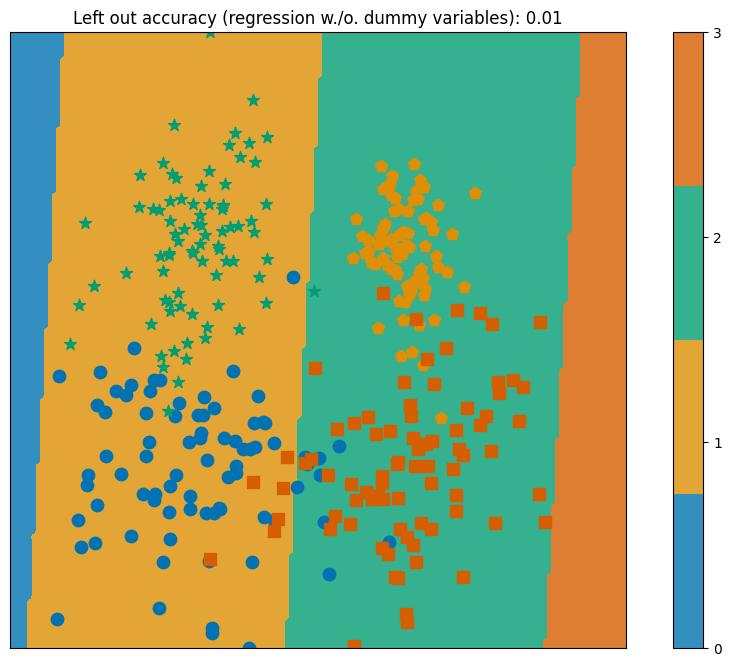

In [16]:
##############################################################################
# Naive linear regression on raw observations
##############################################################################

resolution_param = 150  # 500 for nice plotting, 50 for fast version
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred_test = class_int_round(regr.predict(X_test), n_classes)

# Plotting part
fig0 = plt.figure(figsize=(12, 8))
title = "Left out accuracy (regression w./o. dummy variables)" + \
        ": {:.2f}".format(accuracy_score(y_test, y_pred_test))
plt.title(title)

def f(xx):
    """Classifier"""
    return class_int_round(regr.predict(xx.reshape(1, -1)), n_classes)
frontiere(f, X, y, step=resolution_param)

plt.show()

Instead of using this simple strategy, we can also use a *OneHotEncoder*.

**Question**: Do you see any difference in the resulting decision boundaries ? Which is the best strategy in your opinion ? Why ?

The decision boundaries are different from the first case. In fact, by using OneHotEncoder we move to a higher dimension representation where each prediction contains k different values (k being the number of different classes) . As a result, the model tries to predict each time a probabilty vector (up to a normalization operation). This is much more reliable way to represent categorical labels than the first method. In fact, using indexes to represent classes implies that there is a distance between the different values and thus the model takes into account false error measurements that leads to poor results. In the case of scenario 4 specifically we went from 0.01 left out accuracy to 0.88 by using OneHotEncoding.

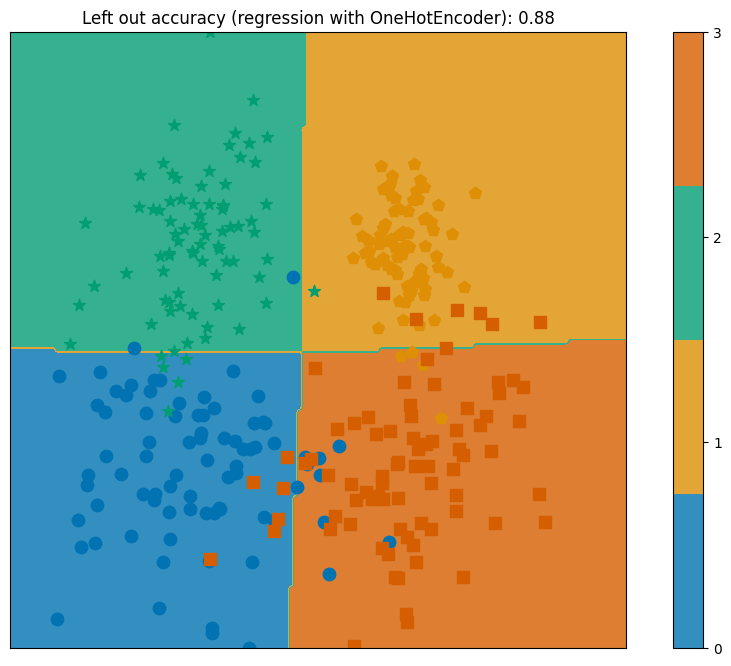

In [17]:
##############################################################################
# Naive linear regression on dummy variables (OneHotEncoder)
##############################################################################
resolution_param = 150
enc = OneHotEncoder(categories='auto')
enc.fit(y_train.reshape(-1, 1))
Y = enc.transform(y_train.reshape(-1, 1)).toarray()
regr_multi = LinearRegression()
regr_multi.fit(X_train, Y)
proba_vector_test = regr_multi.predict(X_test)
#y_pred_test = class_int_round(regr.predict(X_test), n_classes)

# performance evaluation on new dataset
y_pred_test = np.argmax(proba_vector_test, axis=1)
title = "Left out accuracy (regression with OneHotEncoder)" + \
        ": {:.2f}".format(accuracy_score(y_test, y_pred_test))

# Plotting part
fig1 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return np.argmax(regr_multi.predict(xx.reshape(1, -1)))
frontiere(f, X, y, step=resolution_param)

plt.show()

Let's use the other strategies seen this morning.

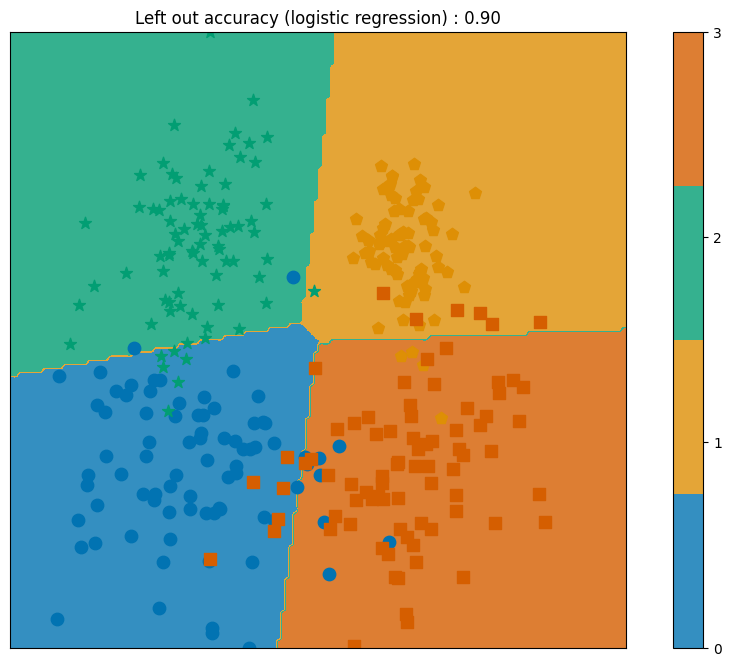

In [26]:
##############################################################################
# Logistic regression
##############################################################################
resolution_param = 150
clf = LogisticRegression(solver='lbfgs',multi_class='ovr') # you can also try multi_class='multinomial',
clf.fit(X_train, y_train)
y_logit_test = clf.predict(X_test)
title = "Left out accuracy (logistic regression) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_logit_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf.predict(xx.reshape(1, -1))[0])
frontiere(f, X, y, step=resolution_param)

plt.show()

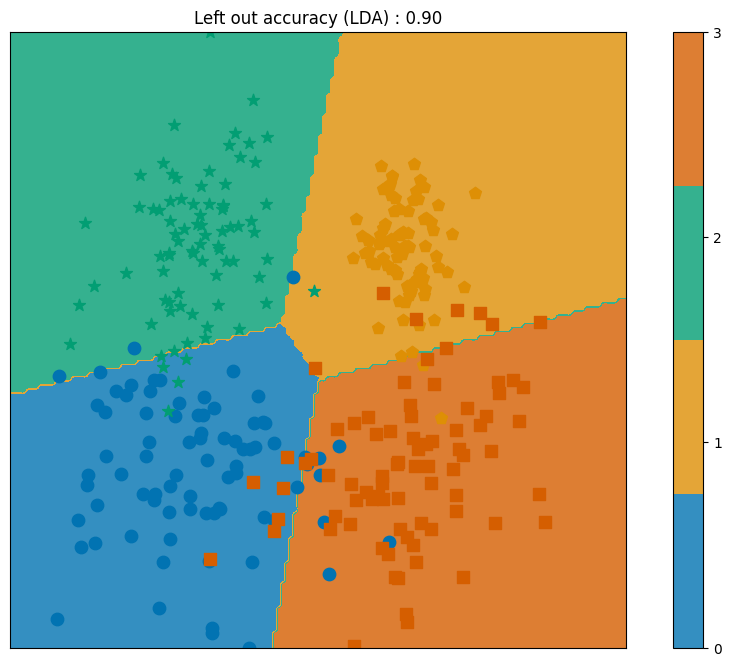

In [27]:
##############################################################################
# LDA
##############################################################################
resolution_param = 150
clf_LDA = LinearDiscriminantAnalysis()
clf_LDA.fit(X_train, y_train)
y_LDA_test = clf_LDA.predict(X_test)

title = "Left out accuracy (LDA) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_LDA_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_LDA.predict(xx.reshape(1, -1))[0])
frontiere(f, X, y, step=resolution_param)

plt.show()

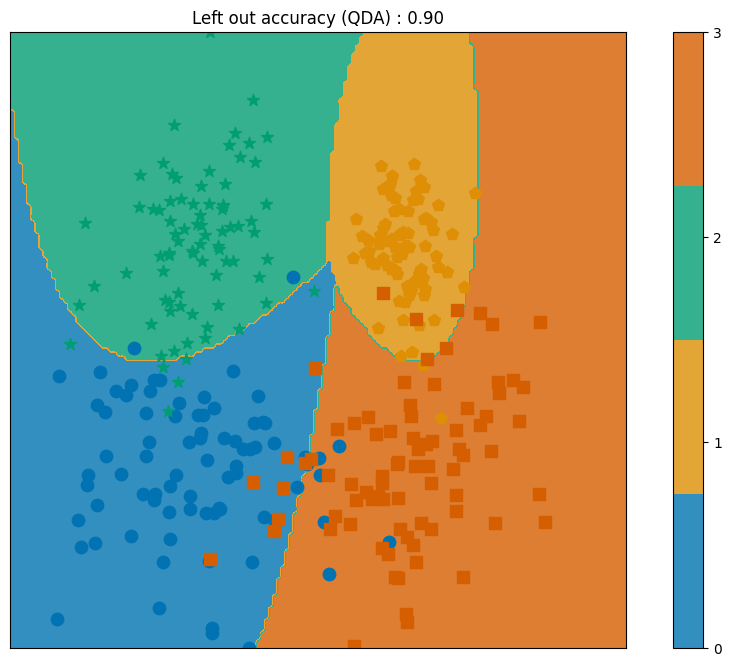

In [28]:
##############################################################################
# QDA
##############################################################################
resolution_param = 150
clf_QDA = QuadraticDiscriminantAnalysis()
clf_QDA.fit(X_train, y_train)
y_QDA_test = clf_QDA.predict(X_test)
title = "Left out accuracy (QDA) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_QDA_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_QDA.predict(xx.reshape(1, -1))[0])
frontiere(f, X, y, step=resolution_param)

plt.show()

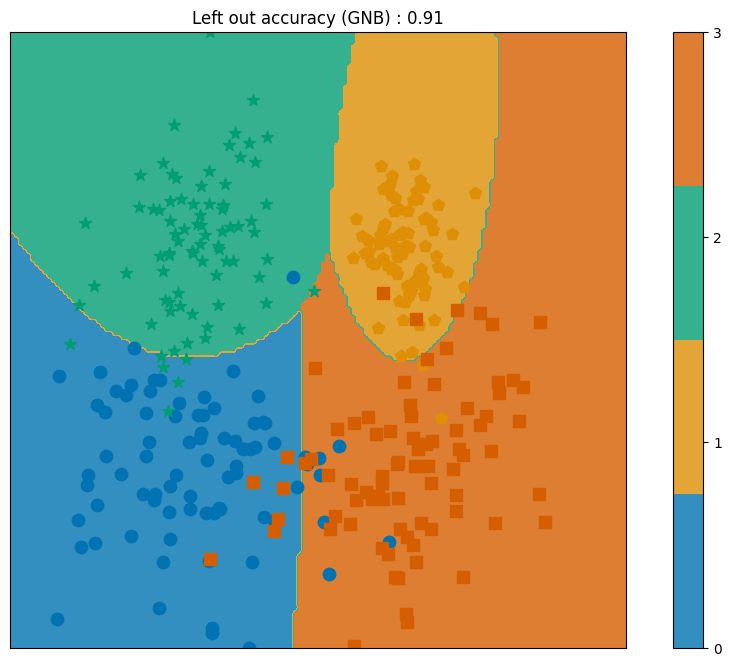

In [29]:
##############################################################################
# Naive Bayes
##############################################################################
resolution_param = 150
clf_GNB = GaussianNB()
clf_GNB.fit(X_train, y_train)

y_test_GNB = clf_GNB.predict(X_test)

title = "Left out accuracy (GNB) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_test_GNB))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)


def f(xx):
    """Classifier"""
    return int(clf_GNB.predict(xx.reshape(1, -1))[0])
frontiere(f, X, y, step=resolution_param)

plt.show()

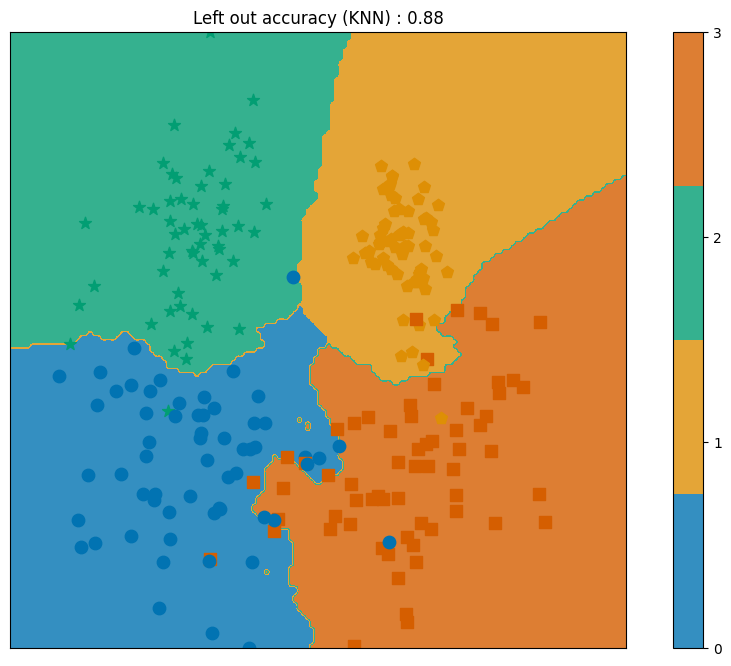

In [34]:
##############################################################################
# KNN
##############################################################################
resolution_param = 150
clf_KNN = KNeighborsClassifier(n_neighbors=5)
#clf_KNN.n_neighbors=5

clf_KNN.fit(X_train, y_train)
y_KNN_test = clf_KNN.predict(X_test)

title = "Left out accuracy (KNN) " + \
        ": {:.2f}".format(accuracy_score(y_test, y_KNN_test))
fig2 = plt.figure(figsize=(12, 8))
plt.title(title)

def f(xx):
    """Classifier"""
    return int(clf_KNN.predict(xx.reshape(1, -1))[0])
frontiere(f, X_train, y_train, step=resolution_param)

plt.show()

**Questions**:


*   Describe the decision boundaries of the methods. Are all linear ?
*   Using the following code, compare the computational time and the test accuracy of the different methods in the three scenarios. Comment the results.
* (Optional) If you change the number of samples per class (both training and test), do the results vary ?



**Answer**

* No, not all the decision boundaries are linear. In fact most of these boundaries are linear expect for the last 3 ones. For the QDA we have quadratic function curve boundaries. For the Naive Bayesian we have both quadratic and linear curves and finally for KNN we have a pretty complex separting boundaries.

* For the linear regression model on raw observations and using OneHotEncoder , LDA ,QDA and Naive bayesian, we noitice a low and stable time cost that is independant of the number of classes but the accuracy decreases for a large number of different classes this decrease is significant in the case of linear regresion on raw observation and reaches 0.03 for scenario 4. However we see a larger computation cost for the case of logistic-regression and KNN-approach

* (Optional) Yes, in theory the number of samples per class should affect the computational time since we are handling more data to learn from.


In [66]:
np.random.seed(42)
# Naive linear regression on raw observations
print("resutls for Naive linear regression on raw observations :")
for scenario in range (2,5):

  #generate the scenario
  X, y = generate_scenario(scenario)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  #mesure performance
  time_start = time.perf_counter()

  regr = LinearRegression()
  regr.fit(X_train, y_train)
  y_pred_test = class_int_round(regr.predict(X_test), n_classes)

  time_elapsed = (time.perf_counter() - time_start)
  print(f"scenario {scenario} : ",'Computational time:', "%.4f" %time_elapsed, 's ; Test accuracy ', "%.2f" %accuracy_score(y_test, y_pred_test))

resutls for Naive linear regression on raw observations :
scenario 2 :  Computational time: 0.0019 s ; Test accuracy  0.97
scenario 3 :  Computational time: 0.0018 s ; Test accuracy  0.90
scenario 4 :  Computational time: 0.0019 s ; Test accuracy  0.03


In [74]:
np.random.seed(42)
# Naive linear regression  (OneHotEncoder)
print("resutls for Naive linear regression (OneHotEncoder) :")
for scenario in range (2,5):

  #generate the scenario
  X, y = generate_scenario(scenario)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
  enc = OneHotEncoder(categories='auto')
  enc.fit(y_train.reshape(-1, 1))
  Y = enc.transform(y_train.reshape(-1, 1)).toarray()
  #mesure performance
  time_start = time.perf_counter()


  regr_multi = LinearRegression()
  regr_multi.fit(X_train, Y)
  proba_vector_test = regr_multi.predict(X_test)
  #y_pred_test = class_int_round(regr.predict(X_test), n_classes)

  # performance evaluation on new dataset
  y_pred_test = np.argmax(proba_vector_test, axis=1)

  time_elapsed = (time.perf_counter() - time_start)
  print(f"scenario {scenario} : ",'Computational time:', "%.4f" %time_elapsed, 's ; Test accuracy ', "%.2f" %accuracy_score(y_test, y_pred_test))

resutls for Naive linear regression (OneHotEncoder) :
scenario 2 :  Computational time: 0.0026 s ; Test accuracy  0.97
scenario 3 :  Computational time: 0.0036 s ; Test accuracy  0.82
scenario 4 :  Computational time: 0.0044 s ; Test accuracy  0.93


In [68]:
np.random.seed(42)
# Logistic regression
print("resutls for Logistic regression :")
for scenario in range (2,5):

  #generate the scenario
  X, y = generate_scenario(scenario)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  #mesure performance
  time_start = time.perf_counter()

  clf = LogisticRegression(solver='lbfgs',multi_class='ovr') # you can also try multi_class='multinomial',
  clf.fit(X_train, y_train)
  y_pred_test = clf.predict(X_test)

  time_elapsed = (time.perf_counter() - time_start)
  print(f"scenario {scenario} : ",'Computational time:', "%.4f" %time_elapsed, 's ; Test accuracy ', "%.2f" %accuracy_score(y_test, y_pred_test))

resutls for Logistic regression :
scenario 2 :  Computational time: 0.0119 s ; Test accuracy  1.00
scenario 3 :  Computational time: 0.0108 s ; Test accuracy  0.93
scenario 4 :  Computational time: 0.0256 s ; Test accuracy  0.93


In [69]:
np.random.seed(42)
# LDA
print("resutls for LDA :")
for scenario in range (2,5):

  #generate the scenario
  X, y = generate_scenario(scenario)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  #mesure performance
  time_start = time.perf_counter()

  clf_LDA = LinearDiscriminantAnalysis()
  clf_LDA.fit(X_train, y_train)
  y_pred_test = clf_LDA.predict(X_test)

  time_elapsed = (time.perf_counter() - time_start)
  print(f"scenario {scenario} : ",'Computational time:', "%.4f" %time_elapsed, 's ; Test accuracy ', "%.2f" %accuracy_score(y_test, y_pred_test))

resutls for LDA :
scenario 2 :  Computational time: 0.0054 s ; Test accuracy  0.97
scenario 3 :  Computational time: 0.0028 s ; Test accuracy  0.92
scenario 4 :  Computational time: 0.0022 s ; Test accuracy  0.93


In [70]:
np.random.seed(42)
# QDA
print("resutls for QDA :")
for scenario in range (2,5):

  #generate the scenario
  X, y = generate_scenario(scenario)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  #mesure performance
  time_start = time.perf_counter()

  clf_QDA = QuadraticDiscriminantAnalysis()
  clf_QDA.fit(X_train, y_train)
  y_pred_test = clf_QDA.predict(X_test)

  time_elapsed = (time.perf_counter() - time_start)
  print(f"scenario {scenario} : ",'Computational time:', "%.4f" %time_elapsed, 's ; Test accuracy ', "%.2f" %accuracy_score(y_test, y_pred_test))

resutls for QDA :
scenario 2 :  Computational time: 0.0016 s ; Test accuracy  1.00
scenario 3 :  Computational time: 0.0017 s ; Test accuracy  0.92
scenario 4 :  Computational time: 0.0022 s ; Test accuracy  0.91


In [71]:
np.random.seed(42)
# Naive Bayes
print("resutls for Naive Bayes :")
for scenario in range (2,5):

  #generate the scenario
  X, y = generate_scenario(scenario)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  #mesure performance
  time_start = time.perf_counter()

  clf_GNB = GaussianNB()
  clf_GNB.fit(X_train, y_train)
  y_pred_test = clf_GNB.predict(X_test)


  time_elapsed = (time.perf_counter() - time_start)
  print(f"scenario {scenario} : ",'Computational time:', "%.4f" %time_elapsed, 's ; Test accuracy ', "%.4f" %accuracy_score(y_test, y_pred_test))

resutls for Naive Bayes :
scenario 2 :  Computational time: 0.0020 s ; Test accuracy  1.0000
scenario 3 :  Computational time: 0.0021 s ; Test accuracy  0.9167
scenario 4 :  Computational time: 0.0023 s ; Test accuracy  0.9125


In [72]:
np.random.seed(42)
# Naive Bayes
print("resutls for Naive Bayes :")
for scenario in range (2,5):

  #generate the scenario
  X, y = generate_scenario(scenario)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

  #mesure performance
  time_start = time.perf_counter()

  clf_KNN = KNeighborsClassifier()
  clf_KNN.n_neighbors=5
  clf_KNN.fit(X_train, y_train)
  y_pred_test = clf_KNN.predict(X_test)


  time_elapsed = (time.perf_counter() - time_start)
  print(f"scenario {scenario} : ",'Computational time:', "%.4f" %time_elapsed, 's ; Test accuracy ', "%.2f" %accuracy_score(y_test, y_pred_test))

resutls for Naive Bayes :
scenario 2 :  Computational time: 0.0078 s ; Test accuracy  1.00
scenario 3 :  Computational time: 0.0090 s ; Test accuracy  0.90
scenario 4 :  Computational time: 0.0103 s ; Test accuracy  0.90
